In [224]:
import csv
import random
import numpy as np
import sklearn as sk
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import impute
from sklearn import feature_selection
from sklearn import tree
from copy import deepcopy

def loadFile(filePath):
    dataset = []
    with open(filePath, 'r') as fd:
        header = next(fd)
        reader = csv.reader(fd, delimiter=';')
        for row in reader:
            for i in range(len(row)):
                row[i] = float(row[i])
            dataset.append(row)
    return dataset, header.replace('"', '').split(';')

def removeValues(dataset, percentage):
    toRemove = int(len(dataset[0])*percentage)
    print(len(dataset), percentage, toRemove)
    for row in dataset:
        for i in range(toRemove):
            feature = int(random.random() * len(row)) 
            row[feature] = np.nan

def handleMissingValues(dataset):
    imp = sk.impute.SimpleImputer(missing_values=np.nan, strategy='mean')
    return imp.fit_transform(dataset)

def applyNormalization(dataset, norm):
    return sk.preprocessing.normalize(dataset, norm=norm)

def applyDiscretization(dataset):
    transf = sk.preprocessing.KBinsDiscretizer(n_bins = 3, encode = 'ordinal', strategy = 'quantile')
    return transf.fit_transform(dataset)

def applyDataReduction(dataset):
    agglo = sk.cluster.FeatureAgglomeration(n_clusters=5)
    return agglo.fit_transform(dataset)

def pearsonCorrelation(dataset, header, target):
    dictPearson = {}
    df = pd.DataFrame(dataset, columns = header)
    y = df[target]          #Target Variable
    X = df.drop(target, axis=1)   #Feature Matrix
    pearson = sk.feature_selection.r_regression(X, y, center=True)
    return pearson

def plotPearson(dataset, header, target, colors):
    pearson = pearsonCorrelation(dataset, header, target)
    headerPearson = deepcopy(header)
    headerPearson.remove(target)
    plt.title('Target Feature: ' + target)
    plt.barh([1,2,3,4,5,6,7,8,9,10,11], pearson, height=0.8, align='center', tick_label=headerPearson,
             color=colors)
    plt.xlim([-1,1])
    plt.show()

def plotAllPearson(dataset, header):
    colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(11)]
    for target in header:
        plotPearson(dataset, header, target, colors)
    
def randomColors(n):
    colors = []
    for i in range(n):
        colors.append(np.random.choice(range(256), size=3))
    print(colors)
    return colors

def decisionTree(df, dataset, target):
    y = df[target]          #Target Variable
    clf = tree.DecisionTreeClassifier(splitter='best', max_features = 8, random_state = 10)
    clf = clf.fit(dataset, y)
    plt.figure(figsize=(40, 40))
    print(df["wine classification"].unique())
    tree.plot_tree(clf, feature_names=header, class_names=["bad","good","medium"])
    

0       medium
1       medium
2       medium
3       medium
4       medium
         ...  
1594    medium
1595    medium
1596    medium
1597    medium
1598    medium
Name: wine classification, Length: 1599, dtype: object
['medium' 'good' 'bad']


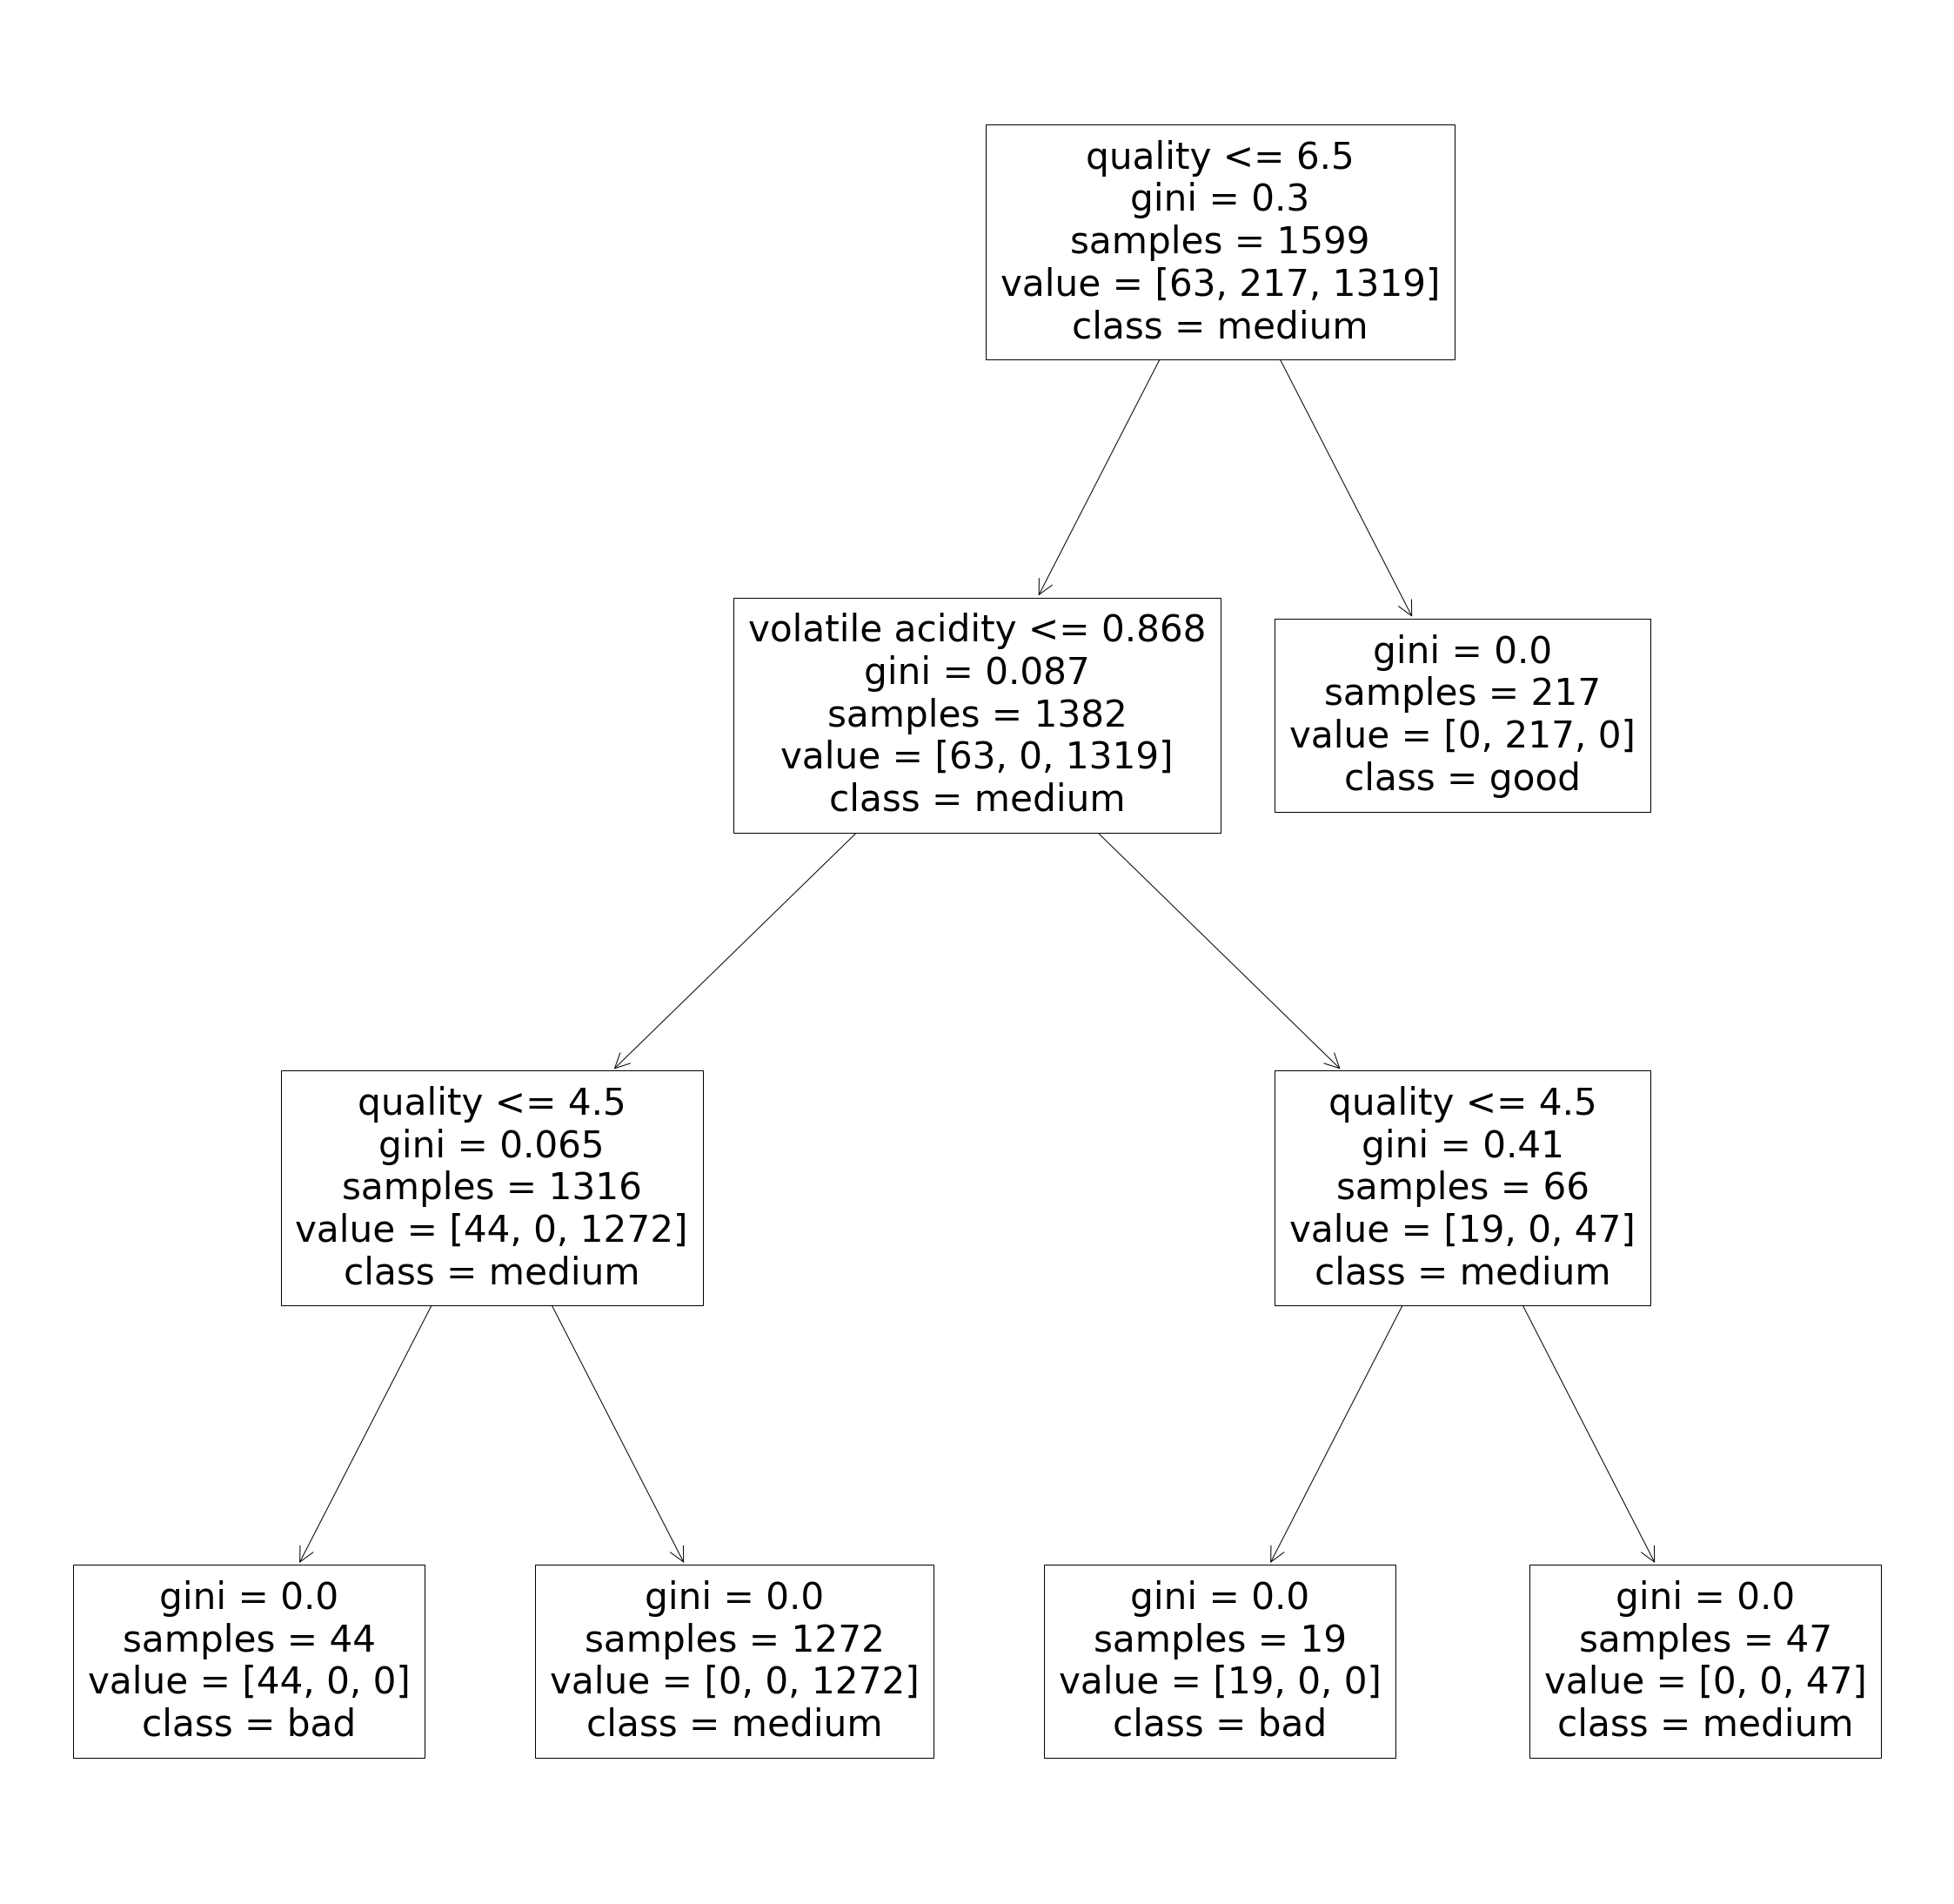

In [228]:
dataset, header = loadFile("./winequality-red.csv")
header[11] = header[11].strip('\n')
#redMissing = removeValues(dataset, 0.1)
#redMissing = handleMissingValues(redMissing)

'''red1 = applyNormalization(dataset, 'l1')
print(red1)
red2 = applyNormalization(red, 'l2')
print(red2)
red3 = applyNormalization(red, 'max')
print(red3)



redRed = applyDataReduction(red)
print(redRed)

redDisc = applyDiscretization(dataset)
'''
df = pd.DataFrame(dataset, columns = header)
df["wine classification"] =  ["good" if i >= 7 else ("bad" if i < 5 else "medium") for i in df['quality']]
print(df["wine classification"])

#plotAllPearson(dataset, header)
decisionTree(df, dataset, "wine classification")



In [186]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
X, y = make_classification(n_samples=100, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    random_state=1)
clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
clf.predict_proba(X_test[:1])

array([[0.03838405, 0.96161595]])